In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from model import YOLOv1
from loss import YoloLoss
from bdd100k import BDD100k
from utils import xywh_to_xyxy, xyxy_to_xywh, intersection_over_union, non_max_supression, precision, recall

In [17]:
'''
Test Data Loader
'''
def test_data_loader(data_loader):
    images, labels = next(iter(data_loader))
    img, label = images[0], labels[0]
    print(labels[0])
    _, height, width = img.shape

    conf = label[..., 13]
    I = torch.nonzero(conf).numpy()
    img = img.to(torch.uint8)
    for index in I:
        i, j = index
        bbox = label[i, j, 14:18].unsqueeze(0)
        bbox[:,0] = width / (7 / (bbox[:,0] + j))
        bbox[:,1] = height / (7 / (bbox[:,1] + i))
        bbox[:,2] = width / (7 / bbox[:,2])
        bbox[:,3] = height / (7 / bbox[:,3])

        bbox = xywh_to_xyxy(bbox, width, height)
        img = draw_bounding_boxes(img, bbox, width=3, colors=(0,255,0))

    img = np.transpose(img.cpu().numpy(), (1,2,0)).astype(np.uint8)
    plt.imshow(img)
    print(len(I))

transform = transforms.Compose([transforms.Resize((448,448))])

train_dataset = BDD100k(root='/Users/calixkim/VIP27920/bdd100k/', train=True, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, 
                            batch_size=8,
                            num_workers=2,
                            shuffle=True)
                            
val_dataset = BDD100k(root='/Users/calixkim/VIP27920/bdd100k/', train=False, transform=transform)
val_loader = data.DataLoader(dataset=val_dataset, 
                            batch_size=8,
                            num_workers=2,
                            shuffle=False)
# test_data_loader(val_loader)

In [59]:
model_ = YOLOv1(split_grids=7, num_bboxes=2, num_classes=13)
model_.load_state_dict(torch.load('/Users/calixkim/VIP27920/Lane_Detection_F22/yolov1//weights/yolov1_150.pt', map_location=torch.device('cpu')))
model_.eval();

In [60]:
def unnorm_bbox(bbox, width, height, i, j):
    '''
    Unormalize the bounding box predictions based on the yolo predictions
    '''
    bbox[:,0] = width / (7 / (bbox[:,0] + j))
    bbox[:,1] = height / (7 / (bbox[:,1] + i))
    bbox[:,2] = width / (7 / bbox[:,2])
    bbox[:,3] = height / (7 / bbox[:,3])

    return bbox

def draw_data_loader(img, label):
    # images, labels = next(iter(data_loader))
    # img, label = images[0], labels[0]

    _, height, width = img.shape

    conf = label[..., 13]
    I = torch.nonzero(conf).numpy()
    img = img.to(torch.uint8)
    ground_truth = []
    for index in I:
        i, j = index
        bbox = label[i, j, 14:18].unsqueeze(0)

        bbox[:,0] = width / (7 / (bbox[:,0] + j))
        bbox[:,1] = height / (7 / (bbox[:,1] + i))
        bbox[:,2] = width / (7 / bbox[:,2])
        bbox[:,3] = height / (7 / bbox[:,3])

        bbox = xywh_to_xyxy(bbox, width, height)
        
        ground_truth.append(torch.cat((torch.tensor([1.]), bbox.squeeze(0))))
        img = draw_bounding_boxes(img, bbox, width=3, colors=(0,255,0))

    img = np.transpose(img.cpu().numpy(), (1,2,0)).astype(np.uint8)
    
    return img, ground_truth

def draw_batch(img, pred, out_dir='./', display=False):
    '''
    Draw the predicted bounding boxes from the network on a single image
    Args:
        img (tensor): image of the predicted bboxes
        pred (tensor): predicted bboxes
        out_dir (str): output directory to store image
        display (bool): display the image or not
    Returns:
    '''
    class_dict = {
        'pedestrian' : 1,
        'rider' : 2,
        'car' : 3,
        'truck' : 4, 
        'bus' : 5, 
        'train' : 6, 
        'motorcycle' : 7,
        'bicycle' : 8,
        'traffic light' : 9,
        'traffic sign' : 10,
        'other vehicle': 11,
        'trailer': 12,
        'other person': 13,
    }
    num_to_class = {i:s for s,i in class_dict.items()}

    s = pred.shape[1]
    img = torch.tensor(img) if not isinstance(img, torch.Tensor) else img
    assert type(pred) == torch.Tensor
    img = img.to(torch.uint8)
    _, height, width = img.shape
    nms = []
    _, pclass = torch.max(pred[:, :, :13], dim=2)
    print("prediction boxes w/ conf > 0.5: ")
    print("================================")
    for i in range(s):
        for j in range(s):
            conf = pred[i, j, 13]
            if conf > 0.5:
                class_pred = num_to_class[pclass[i, j].item()]
                label = [class_pred]
                bbox1 = pred[i, j, 14:18].unsqueeze(0)
                bbox1 = unnorm_bbox(bbox1, width, height, i ,j)
                bbox1 = xywh_to_xyxy(bbox1, width, height)
                bbox2 = pred[i, j, 19:23].unsqueeze(0)
                bbox2 = unnorm_bbox(bbox2, width, height, i ,j)
                bbox2 = xywh_to_xyxy(bbox2, width, height)
                img = draw_bounding_boxes(img, bbox1, width=3, labels=label, colors=(0, 255, 0)) 
                img = draw_bounding_boxes(img, bbox2, width=3, labels=label, colors=(0, 255, 0))
                class_conf = torch.stack((torch.tensor((class_dict[class_pred])), conf))
                nms.append(torch.cat((class_conf, pred[i, j, 14:18])))
                nms.append(torch.cat((class_conf, pred[i, j, 19:23])))
    print(nms)
    nms = non_max_supression(nms, 0, 0.5)
    img = np.transpose(img.cpu().numpy(), (1,2,0)).astype(np.uint8)
    
    return img, nms
    

def draw_nms(img, nms, out_dir='./', display=False):
    '''
    Draw the predicted bounding boxes from the network on a single image
    Args:
        img (tensor): image of the predicted bboxes
        nms (tensor): predicted bboxes after non-max suppression
        out_dir (str): output directory to store image
        display (bool): display the image or not
    Returns:
    '''
    class_dict = {
        'pedestrian' : 1,
        'rider' : 2,
        'car' : 3,
        'truck' : 4, 
        'bus' : 5, 
        'train' : 6, 
        'motorcycle' : 7,
        'bicycle' : 8,
        'traffic light' : 9,
        'traffic sign' : 10,
        'other vehicle': 11,
        'trailer': 12,
        'other person': 13,
    }
    num_to_class = {i:s for s,i in class_dict.items()}

    img = torch.tensor(img) if not isinstance(img, torch.Tensor) else img
    img = img.to(torch.uint8)
    _, height, width = img.shape
    print("===========================")
    print("post nms prediction boxes: ", len(nms))
    print("===========================")
    for x in nms:
        bbox = xywh_to_xyxy(x[2:].unsqueeze(0), width, height)
        label = str(round((x[1].item()),2))
        print(label)
        img = draw_bounding_boxes(img, bbox, width=3, labels=[label], colors=(0,255,0))

    img = np.transpose(img.cpu().numpy(), (1,2,0)).astype(np.uint8)
    
    return img

In [61]:
# Recall
def accuracy(label, nms):
    '''
    Args:
        label (tensor): ground truth bboxes
        nms (list): list of tensors after non max suppression. [class, conf, x, y, w, h]
    Returns:
        tp (int): True Positive
        fp (int): False Positive
        fn (int): False Negative
        tn (int): True Negative
    '''

    tp, fp, fn, tn = (0, 0, 0, 0)
    nms = torch.stack((nms))

    ground_truth_all = []   # [0|1, x, y, w, h] * 49
    s = label.shape[1]
    for i in range(s):
        for j in range(s):
            ground_truth_all.append(label[i, j, 13:18])
    print("ground truth: ")
    print("==============")
    for pred in nms:
        iou_max = 0
        for i, v in enumerate(ground_truth_all):
            iou = intersection_over_union(v[1:].unsqueeze(0), pred[2:].unsqueeze(0))
            if iou > iou_max:
                iou_max = iou
                gt_max_idx = i
    
        if iou_max > 0.1:   # detected
            print(ground_truth_all[gt_max_idx])
            if ground_truth_all[gt_max_idx][0] == 0:
                fp += 1
            else:
                tp += 1
        else:
            fn += 1
            
    tn = 49 - tp - fp - fn
    
    return tp, fp, fn, tn

In [8]:
TP, FP, FN, TN = 0, 0, 0, 0
rec = []
prec = []

for batch_idx, (imgs, labels) in enumerate(val_loader):
    # imgs, labels = next(iter(val_loader))
    for i in range(len(imgs)):
        imgs_ = imgs.clone()
        preds_ = model_(imgs_)
        draw_gt, ground_truth = draw_data_loader(imgs_[i], labels[i])
        draw_preds, nms = draw_batch(imgs_[i], preds_[i])
        tp, fp, fn, tn = accuracy(labels[i], nms)
        TP += tp
        FP += fp
        FN += fn
        TN += tn
        rec.append(recall(TP, FN))
        prec.append(precision(TP, FP))
        
    if batch_idx == 1:
            break



tensor([  1.0000,  85.3776, 225.9267,  26.6395,  31.0552])
tensor([  1.0000, 375.2813, 254.5867,  96.5138,  92.3893])
tensor([  1.0000, 321.8582, 257.3701,  27.9497,  47.3592])
tensor([  1.0000, 284.7374, 203.7998,  11.3546,  17.8567])
tensor([  1.0000,  31.0067, 231.7495,  28.8231,  34.9371])
tensor([  1.0000,  31.0067, 231.7495,  28.8231,  34.9371])
tensor([  1.0000, 113.1089, 185.5549,   4.3671,  10.8693])
tensor([  1.0000, 357.2320, 189.4368,  13.9748,  27.9497])
tensor([  1.0000, 434.5303, 294.2481,  26.2028,  71.4270])
tensor([  1.0000, 299.0227, 184.4344,  24.4206,  20.3217])
tensor([  1.0000, 384.2351, 155.3375,  25.4598,  19.3979])
tensor([  1.0000, 168.1349, 174.6765,   5.3451,   7.8255])
tensor([  1.0000, 232.2289,  97.5394,  10.6902,   7.2665])
tensor([  1.0000, 122.9208, 226.1904,  17.8331,  25.6065])
tensor([  1.0000, 145.8980, 221.9358,  21.9484,  24.4135])
tensor([  1.0000, 145.8980, 221.9358,  21.9484,  24.4135])
tensor([  1.0000, 266.8228, 220.3801,  24.4517,  43.8968

KeyboardInterrupt: 

In [7]:
print(prec)
print(rec)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.3157894736842105, 0.3333333333333333, 0.25, 0.3409090909090909, 0.3698630136986301, 0.37037037037037035, 0.37362637362637363, 0.36283185840707965, 0.36507936507936506, 0.37681159420289856, 0.3885350318471338, 0.391304347826087, 0.40331491712707185, 0.3968253968253968, 0.37799043062200954, 0.3788546255506608, 0.3675889328063241, 0.36704119850187267, 0.36678200692041524, 0.35555555555555557, 0.3404255319148936, 0.32848837209302323, 0.3324175824175824, 0.324468085106383]


In [62]:
imgs, labels = next(iter(val_loader))

prediction boxes w/ conf > 0.5: 
[tensor([  9.0000,   0.8704, 109.5508, 180.8458,   5.6339,  18.2255],
       grad_fn=<CatBackward0>), tensor([  9.0000,   0.8704, 105.1434, 165.0472,  -4.5633,  -3.0660],
       grad_fn=<CatBackward0>), tensor([  9.0000,   0.7533, 215.4897, 187.6128,   3.1550,  13.8583],
       grad_fn=<CatBackward0>), tensor([  9.0000,   0.7533, 209.8483, 181.9551,  -4.8088,   3.6466],
       grad_fn=<CatBackward0>), tensor([ 10.0000,   0.7973, 354.0002, 188.9155,  12.8837,  31.8583],
       grad_fn=<CatBackward0>), tensor([ 10.0000,   0.7973, 337.1850, 168.3791, -12.4027,   2.0474],
       grad_fn=<CatBackward0>), tensor([  3.0000,   0.9162,  29.8804, 232.4639,  23.9998,  37.7158],
       grad_fn=<CatBackward0>), tensor([  3.0000,   0.9162,  48.3372, 228.3925,  30.8562,  26.5627],
       grad_fn=<CatBackward0>), tensor([  3.0000,   1.1467, 107.0199, 229.9538,  26.6034,  39.0864],
       grad_fn=<CatBackward0>), tensor([  3.0000,   1.1467,  84.4779, 228.4865,  23.7536,

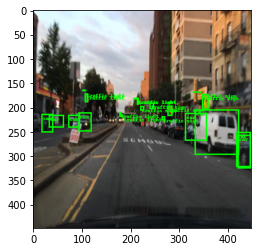

In [63]:
imgs_ = imgs.clone()
preds_ = model_(imgs_)
draw_gt, ground_truth = draw_data_loader(imgs_[0], labels[0])
draw_preds, nms = draw_batch(imgs_[0], preds_[0])
draw_nms_ = draw_nms(imgs_[0], nms)
tp, fp, fn, tn = accuracy(labels[0], nms)
print(tp, fp, fn, tn) 
plt.imshow(draw_preds)

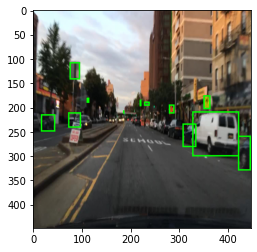

In [38]:
plt.imshow(draw_gt)

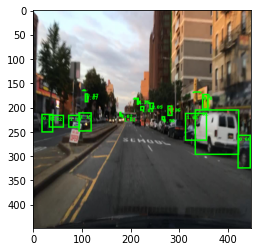

In [39]:
plt.imshow(draw_nms_)

In [ ]:
'''
n = list of batches (e.g. 16)
batch_bboxes = [[], [], ... []] 3d array with length of n. (batch_bboxes[0] = list of bboxes for imgs[0])


'''